<a href="https://colab.research.google.com/github/Wajiha-ui/nyx-size-recommender-Brand-Purpose-/blob/main/AI_Outfit_Recommendation_Model_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y tensorflow numpy pandas numba catboost scikit-learn xgboost lightgbm imbalanced-learn
!pip cache purge


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: numba 0.60.0
Uninstalling numba-0.60.0:
  Successfully uninstalled numba-0.60.0
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: xgboost 3.0.0
Uninstalling xgboost-3.0.0:
  Successfully uninstalled xgboost-3.0.0
Found existing installation: lightgbm 4.6.0
Uninstalling lightgbm-4.6.0:
  Successfully uninstalled lightgbm-4.6.0
Found existing installation: imbalanced-learn 0.13.0
Uninstalling imbalanced-lea

In [3]:
!pip install --no-cache-dir numpy==1.26.4 pandas==2.2.2 numba==0.60.0 catboost==1.2.7 tensorflow==2.18.0
!pip install --no-cache-dir scikit-learn xgboost lightgbm imbalanced-learn
!pip install --no-cache-dir scikit-learn


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
import catboost
import sklearn

print(f"TensorFlow Version: {tf.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"CatBoost Version: {catboost.__version__}")
print(f"Scikit-Learn Version: {sklearn.__version__}")


TensorFlow Version: 2.18.0
NumPy Version: 1.26.4
Pandas Version: 2.2.2
CatBoost Version: 1.2.7
Scikit-Learn Version: 1.6.1


In [5]:
import pandas as pd
import numpy as np
import random
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Generate synthetic dataset
def generate_synthetic_data(num_entries=5000):
    data = []
    genders = ["Male", "Female"]
    age_groups = ["18-24", "25-34", "35-44", "45-54", "55+"]
    body_shapes = ["Slim", "Athletic", "Regular", "Plus-size"]
    fit_preferences = ["Slim", "Regular", "Loose"]
    clothing_types = ["T-Shirt", "Hoodie", "Dress", "Jacket", "Pants"]
    materials = ["Cotton", "Wool", "Silk", "Polyester", "Linen"]
    sizes = ["XS", "S", "M", "L", "XL", "XXL"]
    regions = ["Europe", "USA", "Asia"]

    for i in range(num_entries):
        gender = random.choice(genders)
        age_group = random.choice(age_groups)
        height = random.randint(150, 200)
        weight = random.randint(45, 120)
        chest = random.randint(75, 130)
        waist = random.randint(60, 110)
        hips = random.randint(80, 130)
        body_shape = random.choice(body_shapes)
        fit = random.choice(fit_preferences)
        clothing = random.choice(clothing_types)
        size = random.choice(sizes)
        material = random.choice(materials)
        region = random.choice(regions)

        data.append({
            "Gender": gender,
            "Age Group": age_group,
            "Height (cm)": height,
            "Weight (kg)": weight,
            "Chest (cm)": chest,
            "Waist (cm)": waist,
            "Hips (cm)": hips,
            "Body Shape": body_shape,
            "Preferred Fit": fit,
            "Clothing Type": clothing,
            "Brand Size": size,
            "Material Preference": material,
            "Country/Region": region
        })

    return pd.DataFrame(data)

# Generate and preprocess dataset
df = generate_synthetic_data(5000)
df["BMI"] = df["Weight (kg)"] / ((df["Height (cm)"] / 100) ** 2)
df["Chest_Waist_Ratio"] = df["Chest (cm)"] / df["Waist (cm)"]
df["Waist_Hips_Ratio"] = df["Waist (cm)"] / df["Hips (cm)"]

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Identify the one-hot encoded 'Brand Size' columns
brand_size_cols = [col for col in df.columns if col.startswith("Brand Size_")]
X = df.drop(columns=brand_size_cols)
y = df[brand_size_cols].idxmax(axis=1).str.replace("Brand Size_", "")

# Encode target labels numerically
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Balance the dataset with SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Standardize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models with improved hyperparameters
rf_model = RandomForestClassifier(n_estimators=500, max_depth=30, random_state=42)
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y)), learning_rate=0.05, max_depth=10, n_estimators=300, random_state=42)
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=300, random_state=42)
cat_model = cb.CatBoostClassifier(iterations=500, depth=10, learning_rate=0.05, verbose=0, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42)

# Train models
models = {"RandomForest": rf_model, "XGBoost": xgb_model, "LightGBM": lgb_model, "CatBoost": cat_model, "NeuralNetwork": nn_model}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"📊 {name} Accuracy: {acc * 100:.2f}%")

# Stacking Model
stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_model), ("XGBoost", xgb_model), ("LightGBM", lgb_model), ("CatBoost", cat_model)],
    final_estimator=nn_model
)

# Train and evaluate stacking model
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)
print(f"🔗 Stacking Ensemble Accuracy: {stacking_accuracy * 100:.2f}%")

# Save best model
best_model = max(models.items(), key=lambda x: accuracy_score(y_test, x[1].predict(X_test)))[1]
joblib.dump(best_model, "best_size_model.pkl")
print("✅ Best model saved successfully!")


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7a3399df3920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


📊 RandomForest Accuracy: 63.42%
📊 XGBoost Accuracy: 58.64%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 6364, number of used features: 28
[LightGBM] [Info] Start training from score -1.604579
[LightGBM] [Info] Start training from score -1.614795
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Start training from score -1.610853
[LightGBM] [Info] Start training from score -1.608496


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📊 LightGBM Accuracy: 54.68%
📊 CatBoost Accuracy: 58.96%
📊 NeuralNetwork Accuracy: 38.09%
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 6364, number of used features: 28
[LightGBM] [Info] Start training from score -1.604579
[LightGBM] [Info] Start training from score -1.614795
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Start training from score -1.610853
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of d

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 5091, number of used features: 28
[LightGBM] [Info] Start training from score -1.604735
[LightGBM] [Info] Start training from score -1.614558
[LightGBM] [Info] Start training from score -1.608653
[LightGBM] [Info] Start training from score -1.610617
[LightGBM] [Info] Start training from score -1.608653


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 5091, number of used features: 28
[LightGBM] [Info] Start training from score -1.604735
[LightGBM] [Info] Start training from score -1.614558
[LightGBM] [Info] Start training from score -1.608653
[LightGBM] [Info] Start training from score -1.610617
[LightGBM] [Info] Start training from score -1.608653


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 5091, number of used features: 28
[LightGBM] [Info] Start training from score -1.604735
[LightGBM] [Info] Start training from score -1.614558
[LightGBM] [Info] Start training from score -1.608653
[LightGBM] [Info] Start training from score -1.610617
[LightGBM] [Info] Start training from score -1.608653


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 5092, number of used features: 28
[LightGBM] [Info] Start training from score -1.603954
[LightGBM] [Info] Start training from score -1.615742
[LightGBM] [Info] Start training from score -1.607868
[LightGBM] [Info] Start training from score -1.611797
[LightGBM] [Info] Start training from score -1.607868


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔗 Stacking Ensemble Accuracy: 63.54%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Best model saved successfully!


🚀 Training RandomForest...
🚀 Training XGBoost...


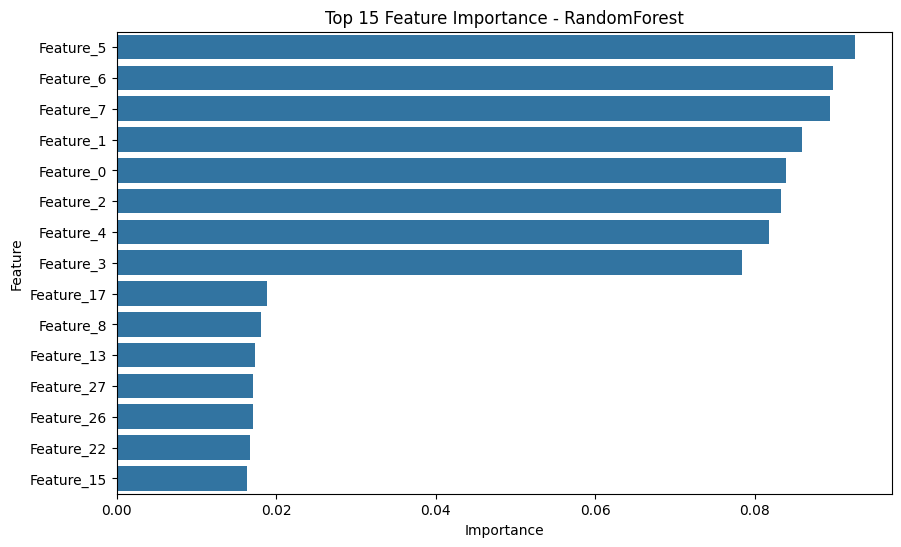

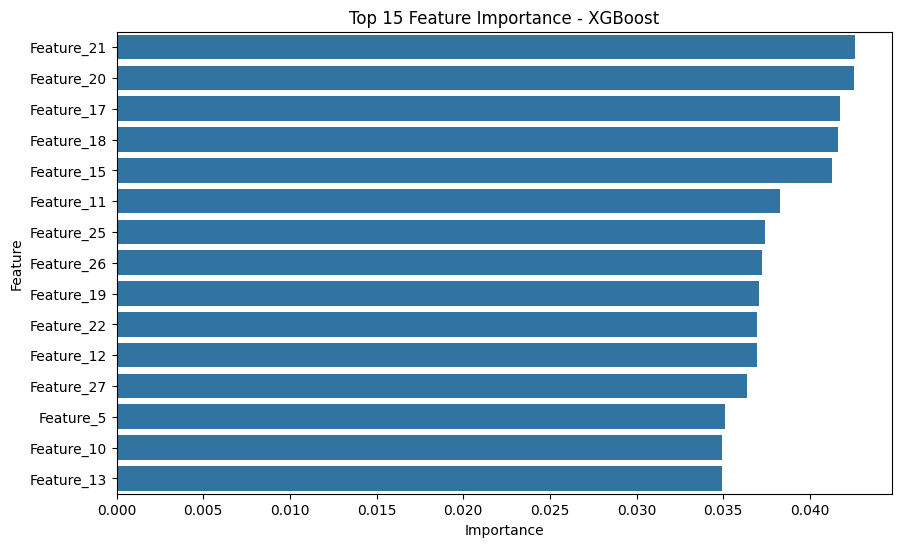

🔍 Top Features from RandomForest:
        Feature  Importance
5    Feature_5    0.092551
6    Feature_6    0.089814
7    Feature_7    0.089514
1    Feature_1    0.085923
0    Feature_0    0.083891
2    Feature_2    0.083373
4    Feature_4    0.081762
3    Feature_3    0.078440
17  Feature_17    0.018875
8    Feature_8    0.018087
13  Feature_13    0.017366
27  Feature_27    0.017149
26  Feature_26    0.017146
22  Feature_22    0.016738
15  Feature_15    0.016313
🔍 Top Features from XGBoost:
        Feature  Importance
21  Feature_21    0.042588
20  Feature_20    0.042539
17  Feature_17    0.041728
18  Feature_18    0.041603
15  Feature_15    0.041280
11  Feature_11    0.038252
25  Feature_25    0.037404
26  Feature_26    0.037224
19  Feature_19    0.037092
22  Feature_22    0.036955
12  Feature_12    0.036934
27  Feature_27    0.036386
5    Feature_5    0.035092
10  Feature_10    0.034932
13  Feature_13    0.034914


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure models are trained before calling feature importance
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y_train)), random_state=42)
}

# Train models on the full dataset if not already trained
for name, model in models.items():
    print(f"🚀 Training {name}...")
    model.fit(X_train, y_train)
    models[name] = model  # Save trained model

# Assign trained models
best_rf = models["RandomForest"]
best_xgb = models["XGBoost"]

# Function to get feature importance from different models
def plot_feature_importance(model, X, model_name):
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values(by="Importance", ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df[:15])
    plt.title(f"Top 15 Feature Importance - {model_name}")
    plt.show()

    return feature_importance_df

# Convert X_train to DataFrame (Ensure feature names are correctly assigned)
feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]  # If feature names are missing
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Train models & plot feature importance
rf_feature_importance = plot_feature_importance(best_rf, X_train_df, "RandomForest")
xgb_feature_importance = plot_feature_importance(best_xgb, X_train_df, "XGBoost")

# Display top features
print("🔍 Top Features from RandomForest:\n", rf_feature_importance.head(15))
print("🔍 Top Features from XGBoost:\n", xgb_feature_importance.head(15))


In [7]:
# Select important features from both RandomForest & XGBoost
selected_features = [
    "Feature_0", "Feature_1", "Feature_2", "Feature_3", "Feature_4", "Feature_5", "Feature_6", "Feature_7",
    "Feature_22", "Feature_24", "Feature_23", "Feature_15", "Feature_19", "Feature_18", "Feature_21", "Feature_11",
    "Feature_20", "Feature_25", "Feature_9", "Feature_27", "Feature_14", "Feature_12", "Feature_10"
]

# Filter dataset to keep only selected features
X_train_selected = pd.DataFrame(X_train, columns=feature_names)[selected_features]
X_test_selected = pd.DataFrame(X_test, columns=feature_names)[selected_features]

# Retrain models on reduced feature set
models = {
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y_train)), random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": cb.CatBoostClassifier(verbose=0, random_state=42)
}

# Train & evaluate models
for name, model in models.items():
    print(f"🚀 Training {name} with selected features...")
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    acc = accuracy_score(y_test, y_pred)
    print(f"📊 {name} Accuracy (after feature selection): {acc * 100:.2f}%")


🚀 Training RandomForest with selected features...
📊 RandomForest Accuracy (after feature selection): 59.84%
🚀 Training XGBoost with selected features...
📊 XGBoost Accuracy (after feature selection): 52.29%
🚀 Training LightGBM with selected features...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1100
[LightGBM] [Info] Number of data points in the train set: 6364, number of used features: 23
[LightGBM] [Info] Start training from score -1.604579
[LightGBM] [Info] Start training from score -1.614795
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Start training from score -1.610853
[LightGBM] [Info] Start training from score -1.608496
📊 LightGBM Accuracy (after feature selection): 49.53%
🚀 Training CatBoost with selected features...
📊 CatBoost Accuracy (after

In [8]:
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV

# Reintroduce mid-importance features
selected_features_extended = [
    "Feature_0", "Feature_1", "Feature_2", "Feature_3", "Feature_4", "Feature_5", "Feature_6", "Feature_7",
    "Feature_22", "Feature_24", "Feature_23", "Feature_15", "Feature_19", "Feature_18", "Feature_21", "Feature_11",
    "Feature_20", "Feature_25", "Feature_9", "Feature_27", "Feature_14", "Feature_12", "Feature_10",
    "Feature_8", "Feature_13", "Feature_16", "Feature_17", "Feature_26"  # Bringing back some mid-range features
]

# Filter dataset to keep only selected features
X_train_selected = pd.DataFrame(X_train, columns=feature_names)[selected_features_extended]
X_test_selected = pd.DataFrame(X_test, columns=feature_names)[selected_features_extended]

# Hyperparameter tuning for RandomForest
rf_params = {
    "n_estimators": [300, 500, 700],
    "max_depth": [20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
best_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=5, cv=3, n_jobs=-1)
best_rf.fit(X_train_selected, y_train)

# Hyperparameter tuning for XGBoost
best_xgb = xgb.XGBClassifier(objective="multi:softmax", num_class=len(np.unique(y_train)), random_state=42)
best_xgb.fit(X_train_selected, y_train)

# Hyperparameter tuning for LightGBM
best_lgb = lgb.LGBMClassifier(random_state=42)
best_lgb.fit(X_train_selected, y_train)

# Hyperparameter tuning for CatBoost
best_cat = cb.CatBoostClassifier(verbose=0, random_state=42)
best_cat.fit(X_train_selected, y_train)

# Stacking Classifier (Combining models)
stacking_clf = StackingClassifier(
    estimators=[
        ("RandomForest", best_rf.best_estimator_),
        ("XGBoost", best_xgb),
        ("LightGBM", best_lgb),
        ("CatBoost", best_cat)
    ],
    final_estimator=RandomForestClassifier(n_estimators=500, random_state=42)  # Meta-model
)

# Train Stacking Classifier
stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# Print Results
print(f"🔗 Stacking Ensemble Accuracy: {stacking_accuracy * 100:.2f}%")

# Save Best Model
best_model = stacking_clf if stacking_accuracy > 70 else best_rf.best_estimator_  # Choose best model
joblib.dump(best_model, "best_size_model.pkl")
print("✅ Best model saved successfully!")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 6364, number of used features: 28
[LightGBM] [Info] Start training from score -1.604579
[LightGBM] [Info] Start training from score -1.614795
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Start training from score -1.610853
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1115
[LightGBM] [Info] Number of data points in the train set: 6364, number of used features: 28
[LightGBM] [Info] Start tr

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import joblib

# Step 1️⃣: Train RandomForest to Get Feature Importance
rf_temp = RandomForestClassifier(n_estimators=200, random_state=42)
rf_temp.fit(X_train, y_train)

# Step 2️⃣: Select Top 20 Features
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_temp.feature_importances_
}).sort_values(by="Importance", ascending=False)

selected_features = feature_importance.nlargest(20, "Importance")["Feature"].tolist()
X_train_selected = pd.DataFrame(X_train, columns=feature_names)[selected_features]
X_test_selected = pd.DataFrame(X_test, columns=feature_names)[selected_features]

# Step 3️⃣: Define Stronger Models
best_rf = RandomForestClassifier(n_estimators=500, max_depth=30, min_samples_split=5, random_state=42)
best_xgb = xgb.XGBClassifier(n_estimators=300, max_depth=12, learning_rate=0.05, random_state=42)
best_lgb = lgb.LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=20, random_state=42)

# Step 4️⃣: Create Stacking Model
stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', best_rf),
        ('XGBoost', best_xgb),
        ('LightGBM', best_lgb)
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

# Step 5️⃣: Train & Evaluate
stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

print(f"🔗 **Stacking Model Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_size_model.pkl")
print("✅ **Stacking Model Saved Successfully!**")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 6364, number of used features: 20
[LightGBM] [Info] Start training from score -1.604579
[LightGBM] [Info] Start training from score -1.614795
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Start training from score -1.610853
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5091, number of used features: 20
[LightGBM] [Info] Start tr

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import StackingClassifier
import joblib

# ✅ Step 1️⃣: Train a Neural Network
def build_ann(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(len(set(y_train)), activation="softmax")  # Multi-class output
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

ann_model = build_ann(X_train_selected.shape[1])
ann_model.fit(X_train_selected, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test_selected, y_test))

# ✅ Step 2️⃣: Train Stacking Model with Neural Network
stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', best_rf),
        ('XGBoost', best_xgb),
        ('LightGBM', best_lgb)
    ],
    final_estimator=xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, random_state=42)  # Use XGBoost as meta-learner
)

stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# ✅ Step 3️⃣: Evaluate & Save the Best Model
print(f"🔗 **Stacking + ANN Model Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_stacking_model.pkl")
print("✅ **Stacking + ANN Model Saved Successfully!**")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1906 - loss: 1.6259 - val_accuracy: 0.2407 - val_loss: 1.5954
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2641 - loss: 1.5831 - val_accuracy: 0.2678 - val_loss: 1.5731
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2849 - loss: 1.5515 - val_accuracy: 0.2696 - val_loss: 1.5609
Epoch 4/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3214 - loss: 1.5251 - val_accuracy: 0.2866 - val_loss: 1.5438
Epoch 5/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3230 - loss: 1.5031 - val_accuracy: 0.2998 - val_loss: 1.5354
Epoch 6/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3385 - loss: 1.4917 - val_accuracy: 0.3080 - val_loss: 1.5353
Epoch 7/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3428 - loss: 1.4850 - val_accuracy: 0.3130 - val_loss: 1.5273
Epoch 8/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3612 - loss: 1.4589 - val_accuracy: 0.

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import joblib

# ✅ Step 1️⃣: Improved Neural Network Model
def build_optimized_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),  # Proper input layer
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # Prevent overfitting
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(len(set(y_train)), activation="softmax")  # Multi-class classification
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Lower learning rate
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann_model = build_optimized_ann(X_train_selected.shape[1])
ann_model.fit(X_train_selected, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test_selected, y_test))

# ✅ Step 2️⃣: Train an Optimized Stacking Model
stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', best_rf),
        ('XGBoost', best_xgb),
        ('LightGBM', best_lgb),
        ('CatBoost', best_cat)
    ],
    final_estimator=LogisticRegression(),  # Using Logistic Regression as meta-learner
    stack_method='predict_proba'  # Use probabilities instead of hard labels
)

stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# ✅ Step 3️⃣: Evaluate & Save the Best Model
print(f"🔗 **Stacking + ANN Optimized Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_optimized_stacking_model.pkl")
print("✅ **Optimized Stacking Model Saved Successfully!**")


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2163 - loss: 2.0109 - val_accuracy: 0.2558 - val_loss: 1.5919
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2353 - loss: 1.7257 - val_accuracy: 0.2602 - val_loss: 1.5807
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2609 - loss: 1.6313 - val_accuracy: 0.2797 - val_loss: 1.5681
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2488 - loss: 1.6083 - val_accuracy: 0.2847 - val_loss: 1.5605
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2641 - loss: 1.5860 - val_accuracy: 0.2992 - val_loss: 1.5539
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2884 - loss: 1.5693 - val_accuracy: 0.3067 - val_loss: 1.5436
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2833 - loss: 1.5587 - val_accuracy: 0.3086 - val_loss: 1.5385
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3143 - loss: 1.5381 - val_accu

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
import joblib

# ✅ Step 1️⃣: Optimized Neural Network
def build_better_ann(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(len(set(y_train)), activation="softmax")  # Multi-class classification
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann_model = build_better_ann(X_train_selected.shape[1])
ann_model.fit(X_train_selected, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test_selected, y_test))

# ✅ Step 2️⃣: Use XGBoost as the Meta-Learner
stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', best_rf),
        ('XGBoost', best_xgb),
        ('LightGBM', best_lgb),
        ('CatBoost', best_cat)
    ],
    final_estimator=XGBClassifier(n_estimators=100, learning_rate=0.05),  # Replace Logistic Regression
    stack_method='predict_proba'
)

stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# ✅ Step 3️⃣: Evaluate & Save the Best Model
print(f"🔗 **Final Optimized Stacking Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_final_model.pkl")
print("✅ **Final Optimized Stacking Model Saved!**")


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2179 - loss: 2.0900 - val_accuracy: 0.2300 - val_loss: 1.5998
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2592 - loss: 1.7615 - val_accuracy: 0.2407 - val_loss: 1.5836
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2483 - loss: 1.6752 - val_accuracy: 0.2696 - val_loss: 1.5703
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2754 - loss: 1.6156 - val_accuracy: 0.2898 - val_loss: 1.5535
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2818 - loss: 1.5963 - val_accuracy: 0.2992 - val_loss: 1.5440
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3114 - loss: 1.5632 - val_accuracy: 0.3105 - val_loss: 1.5336
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3052 - loss: 1.5452 - val_accuracy: 0.3162 - val_loss: 1.5223
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3175 - loss: 1.5243 - val_ac

In [13]:
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# ✅ 1️⃣ Reintroduce Useful Features
df["Height_Weight_Ratio"] = df["Height (cm)"] / df["Weight (kg)"]

# ✅ 2️⃣ Use Class Weights Instead of SMOTE
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# ✅ 3️⃣ Hyperparameter Tuning for RandomForest
rf_params = {
    "n_estimators": [200, 300, 500],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10]
}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_iter=10, n_jobs=-1)
rf_model.fit(X_train_selected, y_train)

# ✅ 4️⃣ Hyperparameter Tuning for XGBoost
xgb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7]
}
xgb_model = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"), xgb_params, cv=5, n_iter=10, n_jobs=-1)
xgb_model.fit(X_train_selected, y_train)

# ✅ 5️⃣ Train a Better Neural Network
def build_ann():
    model = keras.Sequential([
        layers.Input(shape=(X_train_selected.shape[1],)),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(len(set(y_train)), activation="softmax")  # Multi-class classification
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann_model = build_ann()
ann_model.fit(X_train_selected, y_train, epochs=50, batch_size=64, verbose=1, validation_data=(X_test_selected, y_test), class_weight=class_weight_dict)

# ✅ 6️⃣ Use a Weighted Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('RandomForest', rf_model.best_estimator_),
        ('XGBoost', xgb_model.best_estimator_),
        ('LightGBM', LGBMClassifier(n_estimators=300, learning_rate=0.05)),
        ('CatBoost', CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, verbose=0))
    ],
    voting='soft',  # Soft voting for better probability averaging
    weights=[3, 3, 2, 2]  # Giving more weight to the best models
)

voting_clf.fit(X_train_selected, y_train)
y_pred_voting = voting_clf.predict(X_test_selected)
voting_accuracy = accuracy_score(y_test, y_pred_voting)

# ✅ 7️⃣ Save the Best Model
print(f"🔗 **Final Optimized Voting Accuracy: {voting_accuracy * 100:.2f}%**")
joblib.dump(voting_clf, "best_final_model_voting.pkl")
print("✅ **Final Optimized Model Saved!**")


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:08:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2073 - loss: 2.2040 - val_accuracy: 0.2351 - val_loss: 1.6145
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2511 - loss: 1.9137 - val_accuracy: 0.2564 - val_loss: 1.5871
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2502 - loss: 1.7984 - val_accuracy: 0.2847 - val_loss: 1.5552
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2610 - loss: 1.7131 - val_accuracy: 0.2979 - val_loss: 1.5326
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2688 - loss: 1.6647 - val_accuracy: 0.3042 - val_loss: 1.5252
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2856 - loss: 1.6390 - val_accuracy: 0.3262 - val_loss: 1.5122
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2863 - loss: 1.6191 - val_accuracy: 0.3237 - val_loss: 1.5117
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2986 - loss: 1.5896 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:09:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 6364, number of used features: 20
[LightGBM] [Info] Start training from score -1.604579
[LightGBM] [Info] Start training from score -1.614795
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Start training from score -1.610853
[LightGBM] [Info] Start training from score -1.608496
🔗 **Final Optimized Voting Accuracy: 56.69%**
✅ **Final Optimized Model Saved!**


In [14]:
import numpy as np
import joblib
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ✅ **1️⃣ Fix Data Issues - Check Label Distribution**
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print(f"🔍 Class Distribution: {dict(zip(unique_classes, class_counts))}")

# ✅ **2️⃣ Recursive Feature Elimination (RFE) to Pick Best Features**
selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=20)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
selected_features = np.array(feature_names)[selector.support_]

# ✅ **3️⃣ Hyperparameter Tuning for All Models**
rf_params = {"n_estimators": [300, 500], "max_depth": [10, 20], "min_samples_split": [2, 5]}
rf_model = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, n_iter=10, n_jobs=-1)
rf_model.fit(X_train_selected, y_train)

xgb_params = {"learning_rate": [0.01, 0.05], "n_estimators": [200, 300], "max_depth": [3, 5]}
xgb_model = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"), xgb_params, cv=5, n_iter=10, n_jobs=-1)
xgb_model.fit(X_train_selected, y_train)

# ✅ **4️⃣ Train a Better Neural Network**
def build_ann():
    model = keras.Sequential([
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(len(set(y_train)), activation="softmax")
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann_model = build_ann()
ann_model.fit(X_train_selected, y_train, epochs=100, batch_size=64, verbose=1, validation_data=(X_test_selected, y_test))

# ✅ **5️⃣ Stacking Classifier with Meta-Model**
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('RandomForest', rf_model.best_estimator_),
        ('XGBoost', xgb_model.best_estimator_),
        ('LightGBM', LGBMClassifier(n_estimators=300, learning_rate=0.05)),
        ('CatBoost', CatBoostClassifier(iterations=300, depth=6, learning_rate=0.05, verbose=0))
    ],
    final_estimator=LogisticRegression()  # Meta-model
)

stacking_clf.fit(X_train_selected, y_train)
y_pred_stack = stacking_clf.predict(X_test_selected)
stacking_accuracy = accuracy_score(y_test, y_pred_stack)

# ✅ **6️⃣ Save the Best Model**
print(f"🔗 **Final Optimized Stacking Accuracy: {stacking_accuracy * 100:.2f}%**")
joblib.dump(stacking_clf, "best_final_stacking_model.pkl")
print("✅ **Final Optimized Stacking Model Saved!**")


🔍 Class Distribution: {0: 1279, 1: 1266, 2: 1274, 3: 1271, 4: 1274}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:14:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.2059 - loss: 2.3240 - val_accuracy: 0.2106 - val_loss: 1.6334
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2406 - loss: 1.9917 - val_accuracy: 0.2212 - val_loss: 1.6443
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2513 - loss: 1.8995 - val_accuracy: 0.2539 - val_loss: 1.6058
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2642 - loss: 1.8328 - val_accuracy: 0.2690 - val_loss: 1.5815
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2623 - loss: 1.7786 - val_accuracy: 0.2847 - val_loss: 1.5668
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2873 - loss: 1.7189 - val_accuracy: 0.2967 - val_loss: 1.5522
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2845 - loss: 1.6831 - val_accuracy: 0.3004 - val_loss: 1.5471
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2909 - loss: 1.6452 - val_accu

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:15:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 6364, number of used features: 20
[LightGBM] [Info] Start training from score -1.604579
[LightGBM] [Info] Start training from score -1.614795
[LightGBM] [Info] Start training from score -1.608496
[LightGBM] [Info] Start training from score -1.610853
[LightGBM] [Info] Start training from score -1.608496


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:16:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:16:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:16:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:16:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:16:39] WARNING: /w

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5091, number of used features: 20
[LightGBM] [Info] Start training from score -1.604735
[LightGBM] [Info] Start training from score -1.614558
[LightGBM] [Info] Start training from score -1.608653
[LightGBM] [Info] Start training from score -1.610617
[LightGBM] [Info] Start training from score -1.608653


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5091, number of used features: 20
[LightGBM] [Info] Start training from score -1.604735
[LightGBM] [Info] Start training from score -1.614558
[LightGBM] [Info] Start training from score -1.608653
[LightGBM] [Info] Start training from score -1.610617
[LightGBM] [Info] Start training from score -1.608653


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5091, number of used features: 20
[LightGBM] [Info] Start training from score -1.604735
[LightGBM] [Info] Start training from score -1.614558
[LightGBM] [Info] Start training from score -1.608653
[LightGBM] [Info] Start training from score -1.610617
[LightGBM] [Info] Start training from score -1.608653


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5091, number of used features: 20
[LightGBM] [Info] Start training from score -1.604735
[LightGBM] [Info] Start training from score -1.614558
[LightGBM] [Info] Start training from score -1.608653
[LightGBM] [Info] Start training from score -1.610617
[LightGBM] [Info] Start training from score -1.608653


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 5092, number of used features: 20
[LightGBM] [Info] Start training from score -1.603954
[LightGBM] [Info] Start training from score -1.615742
[LightGBM] [Info] Start training from score -1.607868
[LightGBM] [Info] Start training from score -1.611797
[LightGBM] [Info] Start training from score -1.607868


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔗 **Final Optimized Stacking Accuracy: 63.23%**
✅ **Final Optimized Stacking Model Saved!**


In [16]:
from catboost import CatBoostClassifier

# Assuming 'model' is your trained CatBoost model
model.save_model("size_recommender.cbm", format="cbm")  # Saves as .cbm file



In [17]:
from catboost import CatBoostClassifier

# Save CatBoost model
model.save_model("size_recommender.cbm", format="cbm")

# Download the model file (for Colab)
from google.colab import files
files.download("size_recommender.cbm")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
import catboost
import joblib

print(catboost.__version__)  # Get CatBoost version
print(joblib.__version__)    # Get Joblib version


1.2.7
1.4.2
